100%|██████████| 170498071/170498071 [00:02<00:00, 72070752.18it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Train Epoch: 1 [0/50000 (0%)]	Loss: 2.300395
Train Epoch: 1 [6400/50000 (13%)]	Loss: 1.978526
Train Epoch: 1 [12800/50000 (26%)]	Loss: 1.927698
Train Epoch: 1 [19200/50000 (38%)]	Loss: 1.883743
Train Epoch: 1 [25600/50000 (51%)]	Loss: 1.960322
Train Epoch: 1 [32000/50000 (64%)]	Loss: 1.760417
Train Epoch: 1 [38400/50000 (77%)]	Loss: 1.850579
Train Epoch: 1 [44800/50000 (90%)]	Loss: 1.874157
Training Accuracy: 25.95%

Test set: Average loss: 0.0295, Accuracy: 2791/10000 (28%)

Train Epoch: 2 [0/50000 (0%)]	Loss: 2.060480
Train Epoch: 2 [6400/50000 (13%)]	Loss: 1.670128
Train Epoch: 2 [12800/50000 (26%)]	Loss: 2.164754
Train Epoch: 2 [19200/50000 (38%)]	Loss: 1.593495
Train Epoch: 2 [25600/50000 (51%)]	Loss: 1.663067
Train Epoch: 2 [32000/50000 (64%)]	Loss: 1.645373
Train Epoch: 2 [38400/50000 (77%)]	Loss: 1.583351
Train Epoch: 2 [44800/50000 (90%)]	Loss: 1.404571
Training Accuracy: 34.21%

Test set:

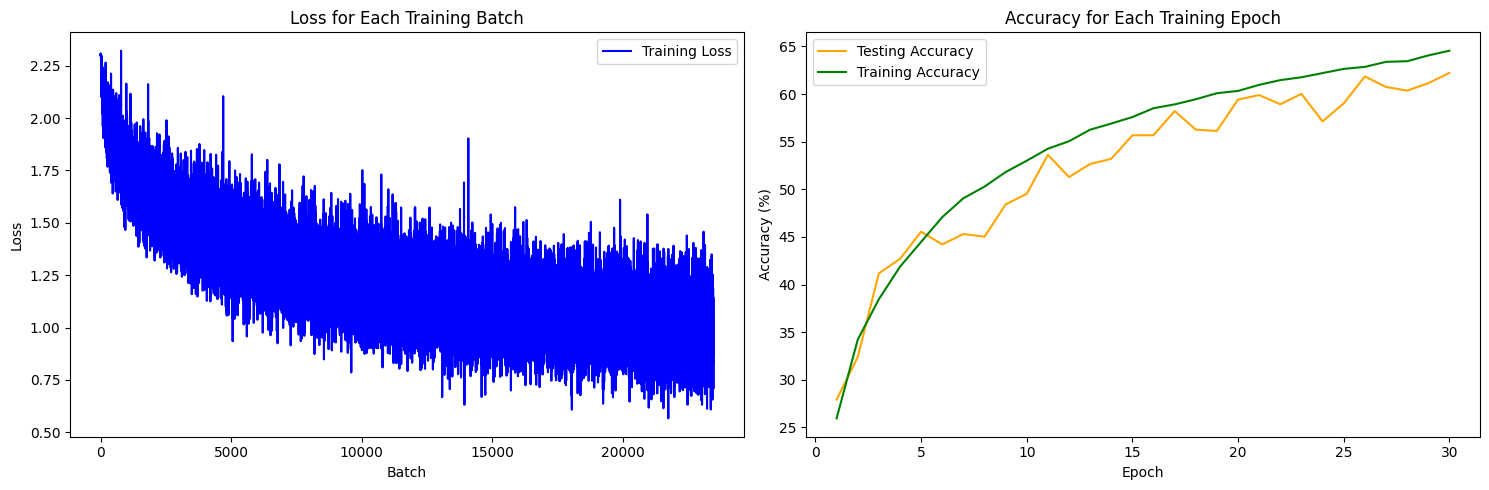

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Data preparation with normalization and augmentation for training
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),  # Data Augmentation
    transforms.RandomHorizontalFlip(),     # Data Augmentation
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Data preparation with normalisation for testing
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

# Neural Network Architecture
class IntermediateBlock(nn.Module):
    def __init__(self, in_channels, num_convs, out_channels):
        super(IntermediateBlock, self).__init__()
        self.convs = nn.ModuleList([
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1) for _ in range(num_convs)
        ])
        self.fc = nn.Linear(in_channels, num_convs)  # Adjusted to use in_channels
        self.dropout = nn.Dropout(0.5)  # Dropout for regularisation

    def forward(self, x):
        m = torch.mean(x, dim=[2, 3])
        a = torch.softmax(self.fc(m), dim=1)
        x_primes = [conv(x) for conv in self.convs]
        x_prime = torch.zeros_like(x_primes[0])
        for i, xp in enumerate(x_primes):
            x_prime += a[:, i].unsqueeze(1).unsqueeze(2).unsqueeze(3) * self.dropout(xp)  # Applies dropout
        return x_prime


class OutputBlock(nn.Module):
    def __init__(self, in_channels, num_classes, hidden_sizes=[256, 128, 64]):
        super(OutputBlock, self).__init__()

        # The first fully connected layer from in_channels to the first hidden layer size
        self.fc1 = nn.Linear(in_channels, hidden_sizes[0])

        # Additional fully connected layers based on the specified hidden_sizes
        self.fc2 = nn.Linear(hidden_sizes[0], hidden_sizes[1])
        self.fc3 = nn.Linear(hidden_sizes[1], hidden_sizes[2])

        # The final fully connected layer that outputs the class logits
        self.fc4 = nn.Linear(hidden_sizes[2], num_classes)

    def forward(self, x):
        # Compute the average across spatial dimensions to get a feature vector
        m = x.mean([2, 3])

        # Sequentially pass through the fully connected layers with ReLU activations
        m = F.relu(self.fc1(m))
        m = F.relu(self.fc2(m))
        m = F.relu(self.fc3(m))
        o = self.fc4(m)

        return o

class CIFAR10Net(nn.Module):
    def __init__(self):
        super(CIFAR10Net, self).__init__()
        self.block1 = IntermediateBlock(3, 2, 32)
        self.block2 = IntermediateBlock(32, 2, 64)
        self.output_block = OutputBlock(64, 10)

    def forward(self, x):
        x = F.relu(self.block1(x))
        x = F.relu(self.block2(x))
        x = self.output_block(x)
        return x

# Initialise model, criterion, optimizer, and apply Xavier initialization
model = CIFAR10Net()

def initialize_weights(m):
    if isinstance(m, (nn.Conv2d, nn.Linear)):
        nn.init.xavier_uniform_(m.weight)
        nn.init.constant_(m.bias, 0)

model.apply(initialize_weights)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Training and Testing
def train(epoch, log_interval=100):
    model.train()
    losses = []
    correct = 0
    total = 0

    for batch_idx, (data, target) in enumerate(train_loader):
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        # Compute training accuracy
        _, predicted = torch.max(output.data, 1)
        total += target.size(0)
        correct += (predicted == target).sum().item()

        if batch_idx % log_interval == 0:
            print(f'Train Epoch: {epoch} [{batch_idx * len(data)}/{len(train_loader.dataset)} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}')

    train_accuracy = 100 * correct / total
    print(f'Training Accuracy: {train_accuracy:.2f}%')
    return losses, train_accuracy

def test():
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            output = model(data)
            test_loss += criterion(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({accuracy:.0f}%)\n')

    return accuracy

# Execute Training and Testing
train_losses = []
train_accuracies = []
test_accuracies = []
for epoch in range(1, 31):
    train_loss, train_accuracy = train(epoch)
    test_accuracy = test()
    train_losses.extend(train_loss)
    train_accuracies.append(train_accuracy)
    test_accuracies.append(test_accuracy)

# Plotting
plt.figure(figsize=(15, 5))

# Loss plot for each training batch
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss', color='blue')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Loss for Each Training Batch')
plt.legend()

# Accuracy plot for each training epoch
plt.subplot(1, 2, 2)
epochs = range(1, len(test_accuracies) + 1)
plt.plot(epochs, test_accuracies, label='Testing Accuracy', color='orange')
plt.plot(epochs, train_accuracies, label='Training Accuracy', color='green')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy for Each Training Epoch')
plt.legend()

plt.tight_layout()
plt.show()
